# Predict cryo-CARE

In this notebook we will take the two reconstructed (even/odd) tomograms and apply the trained network to them. Afterwards we will average them voxel-wise to get our final restored tomogram.

In [1]:
from train_cryo_care import CryoCARE
from generate_train_data import normalize, compute_mean_std, denormalize

import mrcfile
import numpy as np

from matplotlib import pyplot as plt

Using TensorFlow backend.


## Load Tomograms

In [2]:
even = mrcfile.open('data/Tomo110/frames/even/Tomo110_even.rec').data
odd = mrcfile.open('data/Tomo110/frames/odd/Tomo110_odd.rec').data

In [3]:
# We load mean and standard deviation that where used to normalize the training data
mean_std = np.load('data/Tomo110/train_data/mean_std.npz')
mean, std = mean_std['mean'], mean_std['std']
print(mean, std)

0.08776268 2.0187595


In [4]:
# Normalize the data
even_n = normalize(even, mean, std)
odd_n = normalize(odd, mean, std)

## Load Network

In [5]:
model = CryoCARE(None, 'Tomo110_model', basedir='data/Tomo110/')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Loading network weights from 'weights_best.h5'.


## Apply Network

In [6]:
# We denoise the normalized data and denormalize it. This means the intensities 
# are transformed back into the original data range.
# Note: We set 'normalizer=None' since we already normalized the data. 
even_denoised = denormalize(model.predict(even_n, axes='ZYX', n_tiles=(2,4,4), normalizer=None), mean, std)

100%|██████████| 32/32 [05:24<00:00, 10.14s/it]  


In [7]:
odd_denoised = denormalize(model.predict(odd_n, axes='ZYX', n_tiles=(2,4,4), normalizer=None), mean, std)

100%|██████████| 32/32 [05:25<00:00, 10.18s/it]  


In [8]:
# Voxel wise averaging of the two halves.
tomo_denoised = (even_denoised + odd_denoised)/2.0

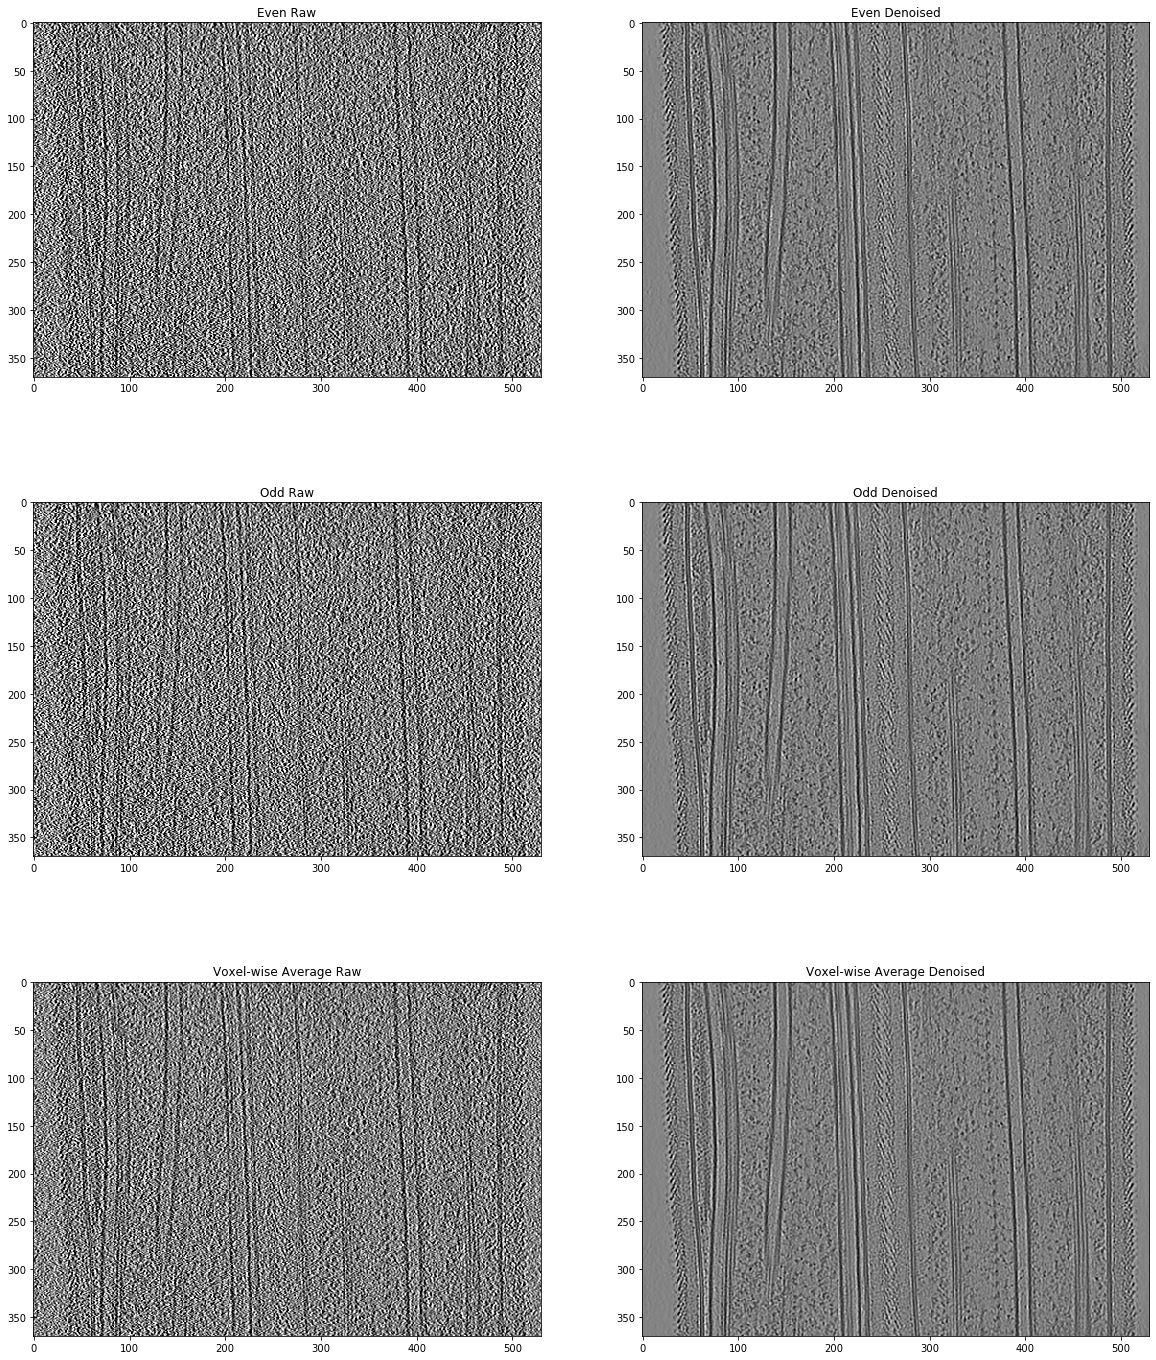

In [9]:
plt.figure(figsize=(20,25))
plt.subplot(3,2,1)
plt.imshow(even[108, 350:720, 350:880], cmap='gray', vmin=-3, vmax=3)
plt.title('Even Raw');
plt.subplot(3,2,2)
plt.imshow(even_denoised[108, 350:720, 350:880], cmap='gray', vmin=-3, vmax=3)
plt.title('Even Denoised');
plt.subplot(3,2,3)
plt.imshow(odd[108, 350:720, 350:880], cmap='gray', vmin=-3, vmax=3)
plt.title('Odd Raw');
plt.subplot(3,2,4)
plt.imshow(odd_denoised[108, 350:720, 350:880], cmap='gray', vmin=-3, vmax=3)
plt.title('Odd Denoised');
plt.subplot(3,2,5)
plt.imshow(((even+odd)/2.0)[108, 350:720, 350:880], cmap='gray', vmin=-3, vmax=3)
plt.title('Voxel-wise Average Raw');
plt.subplot(3,2,6)
plt.imshow(tomo_denoised[108, 350:720, 350:880], cmap='gray', vmin=-3, vmax=3)
plt.title('Voxel-wise Average Denoised');

In [10]:
# Save the denoised tomogram.
with mrcfile.open('data/Tomo110/Tomo110_denoised.mrc', 'w+') as mrc:
    mrc.set_data(tomo_denoised)